In [1]:
%%writefile libTest.py

import numpy as np
from random_radon_transform import random_radon_transformation

from matplotlib import pyplot as plt

def create_line(img, a, b):
    d = (np.cos(b * np.pi), np.sin(b * np.pi))
    l = (img.shape[0] ** 2 + img.shape[1] ** 2) ** 0.5
    r = 2 * l * a
    px = np.linspace(-d[0] * l, d[0] * l, int(4 * l), endpoint=False).astype(int)
    py = np.linspace(-d[1] * l, d[1] * l, int(4 * l), endpoint=False).astype(int)
    px += int(-r * d[1])
    py += int(r * d[0])
    for x, y in zip(px, py):
        if (x >= 0) & (x < img.shape[0]) & (y >= 0) & (y < img.shape[1]):
            img[x, y] = 1

def revert_radon(img, rrt):
    sh = rrt.shape
    for x in range(sh[0]):
        for y in range(sh[1]):
            if rrt[x, y] > 0.5:
                create_line(img, x / sh[0] - 0.5, y / sh[1] - 0.5)
    
def save_result(img, rrt, name, figsize = (12, 6)):
    lin = np.zeros(img.shape)
    zer = np.zeros(img.shape)
    revert_radon(lin, rrt)
    
    fig = plt.figure(figsize = figsize)
    fig.add_subplot(1, 2, 1)
    plt.imshow(np.array((lin, img, zer)).T)
    plt.axis("off")
    plt.title("Image")
    fig.add_subplot(1, 2, 2)
    plt.imshow(rrt)
    plt.axis("off")
    plt.title("Random radon transformation")
    fig.savefig(f"plots/{name}.png")
    plt.close(fig)

def clear_region(array, X, Y):
    if array[X, Y] == 0:
        return
    array[X, Y] = 0
    #for dx, dy in ((1, 0), (0, 1), (-1, 0), (0, -1)):
    for dx in (-1, 0, 1):
        for dy in (-1, 0, 1):
            x = X + dx
            y = Y + dy
            if (x >= 0) & (x < array.shape[0]) & (y >= 0) & (y < array.shape[1]):
                clear_region(array, x, y)

def count(array):
    array = array > 0.5
    c = 0
    for x in range(array.shape[0]):
        for y in range(array.shape[1]):
            c += array[x, y]
            clear_region(array, x, y)
    return c

def transform(img, size, n_iter = 1e5):
    rrt = random_radon_transformation(
        (img == 0) * 255, rho_steps = size[0]//2,
        theta_steps = size[1], n_iter = int(n_iter))
    return rrt / rrt.max() if rrt.max() != 0 else rrt

def plot(img, x0, y0, x1, y1, width = 1, p = 1, looping = True):
    n = int(((x0 - x1) ** 2 + (y0 - y1) ** 2) ** 0.5 + 2)
    px = np.linspace(x0, x1, n, endpoint=True) + 0.5
    py = np.linspace(y0, y1, n, endpoint=True) + 0.5
    d = np.array((x1 - x0, y1 - y0))
    d = d / (d ** 2).sum() ** 0.5
    pw = np.linspace(-(width - 1) / 2, (width - 1) / 2, int(width * 2), endpoint=True)
    for w in pw:
        for x, y in zip(px, py):
            if np.random.uniform() <= p:
                x = int(x - w * d[1] + 0.5)
                y = int(y + w * d[0] + 0.5)
                if looping or ((x >= 0) and (x < img.shape[0]) and
                               (y >= 0) and (y < img.shape[1])):
                    img[x % img.shape[0], y % img.shape[1]] = 1

def random_plot(img, used, width = 1, p = 1):
    check = False
    while ~check:
        if np.random.randint(2):
            x0 = np.random.randint(img.shape[0])
            y0 = img.shape[1] - 1 if np.random.randint(2) else 0
        else:
            x0 = img.shape[0] - 1 if np.random.randint(2) else 0
            y0 = np.random.randint(img.shape[1])
        check = used[x0, y0] == 0
        if not isinstance(check, bool):
            check = check.all()
    check = False
    while ~check:
        if np.random.randint(2):
            x1 = np.random.randint(img.shape[0])
            y1 = img.shape[1] - 1 if np.random.randint(2) else 0
        else:
            x1 = img.shape[0] - 1 if np.random.randint(2) else 0
            y1 = np.random.randint(img.shape[1])
        dx = x1 - x0
        dy = y1 - y0
        length = (dx ** 2 + dy ** 2) ** 0.5
        check = (length > max(img.shape) / 4) & (used[x1, y1] == 0)
        if not isinstance(check, bool):
            check = check.all()
    a, b = 0, 0
    while length * abs(a - b) <= max(img.shape) / 8:
        a, b = np.random.uniform(size = 2)
    plot(img, x0 + a * dx, y0 + a * dy,
         x0 + b * dx, y0 + b * dy, width, p, looping = False)
    plot(used, x0, y0, x1, y1, width + 6, looping = False)

def start(size_img, size_rrt, num, width = 1, p = 1, img = None, Type = 0):
    if img is None:
        img = np.zeros(size_img)
    used = np.zeros(size_img)
    for i in range(num):
        random_plot(img, used, width, p)
    rrt = transform(img, size_rrt)
    '''
    fig = plt.figure(figsize = (8, 4))
    fig.add_subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title("Image")
    fig.add_subplot(1, 2, 2)
    plt.imshow(rrt)
    plt.axis("off")
    plt.title("Random radon transformation")
    plt.show()
    '''
    return img, rrt

def check_num_lines(img, rrt, num, name):
    cnt = count(rrt)
    smm = (rrt > 0.5).sum()
    if (cnt > num) or (smm < num):
        save_result(img, rrt, name)
    assert cnt <= num, f"return {cnt}>{num} lines"
    assert smm >= num, f"return {smm}<{num} lines"

def check_one_line(img, rrt, name, size = None):
    cnt = count(rrt)
    if cnt != 1:
        save_result(img, rrt, name)
        assert (False, f"return {cnt}!=1 lines" +
                ("" if size is None else f", shape={size}"))

def empty_test(size_img, size_rrt, name):
    img, rrt = start(size_img, size_rrt, 0)
    if rrt.max() == 1:
        save_result(img, rrt, name)
        assert False, f"return nonzero array"

def full_test(size_img, size_rrt, name):
    img = np.ones(size_img)
    img, rrt = start(size_img, size_rrt, 0, img = img)
    if (rrt > 0).mean() <= 0.5:
        save_result(img, rrt, name)
        assert False, f"most pixels of output don't used"

def base_test(size_img, size_rrt, name):
    img, rrt = start(size_img, size_rrt, 1)
    check_one_line(img, rrt, name)

def size_1d_test(max_size_img, size_rrt, name):
    size_img = (1, np.random.randint(2, max_size_img))
    if np.random.randint(2):
        size_img = (size_img[1], 1)
    img, rrt = start(size_img, size_rrt, 1)
    cnt = count(rrt)
    check_one_line(img, rrt, name, size_img)

def size_2d_test(max_size_img, size_rrt, name):
    size_img = np.random.randint(2, max_size_img)
    img, rrt = start(size_img, size_rrt, 1)
    check_one_line(img, rrt, name, size_img)

def size_3d_test(max_size_img, size_rrt, name):
    size_img = np.random.randint(2, max_size_img)
    img, rrt = start((*size_img, 3), size_rrt, 1)
    check_one_line(img, rrt, name, size_img)

def sev_obj_test(size_img, size_rrt, num, name):
    check_num_lines(*start(size_img, size_rrt, num), name, num)

def width_test(size_img, size_rrt, width, name):
    img, rrt = start(size_img, size_rrt, 1, width)
    check_one_line(img, rrt, name)
    if (rrt > 0.5).sum() * 2 < width:
        save_result(img, rrt, name)
        assert False, f"return small spot"

def noise_test(size_img, size_rrt, noise, name):
    img = np.random.uniform(size = size_img) < noise
    img, rrt = start(size_img, size_rrt, 1, img = img)
    check_one_line(img, rrt, name)

def partial_test(size_img, size_rrt, p, name):
    img, rrt = start(size_img, size_rrt, 1, p = p)
    check_one_line(img, rrt, name)

def random_plot_parallel(img, used, num, width = 1, p = 1):
    if np.random.randint(2):
        dx = np.random.randint(img.shape[0])
        dy = img.shape[1] - 1 if np.random.randint(2) else 1 - img.shape[1]
    else:
        dx = img.shape[0] - 1 if np.random.randint(2) else 1 - img.shape[1]
        dy = np.random.randint(img.shape[1])
    for i in range(num):
        check = False
        while ~check:
            cx = np.random.randint(img.shape[0])
            cy = np.random.randint(img.shape[1])
            check = used[cx, cy] == 0
            if not isinstance(check, bool):
                check = check.all()
        a, b = 0, 0
        while abs(a - b) <= 1 / 4:
            a, b = np.random.uniform(size = 2) * 2 - 1
        plot(img, cx + a * dx, cy + a * dy, cx + b * dx, cy + b * dy, width, p, looping = False)
        plot(used, cx - dx, cy - dy, cx + dx, cy + dy, width + 6, looping = False)

def parallel_test(size_img, size_rrt, num, name):
    img = np.zeros(size_img)
    used = np.zeros(size_img)
    random_plot_parallel(img, used, num)
    rrt = transform(img, size_rrt)
    check_num_lines(img, rrt, num, name)

def random_plot_loop(img, max_num, width = 1, p = 1, loop = False):
    x0 = np.random.randint(img.shape[0])
    y0 = np.random.randint(img.shape[1])
    x1 = x0 if loop else np.random.randint(img.shape[0])
    y1 = y0 if loop else np.random.randint(img.shape[1])
    d = [0, 0]
    while len({0, abs(d[0]), abs(d[1])}) < 3:
        d = np.random.randint(-max_num, max_num + 1, size = 2)
    x1 += img.shape[0] * d[0]
    y1 += img.shape[1] * d[1]
    plot(img, x0, y0, x1, y1, width, p)

def loop_test(size_img, size_rrt, max_num, loop, name):
    img = np.zeros(size_img)
    random_plot_loop(img, max_num, loop = loop)
    rrt = transform(img, size_rrt)
    if count(rrt) == 1:
        save_result(img, rrt, name)
        assert False, f"return only one line, loop={loop}"

def create_circle(radius):
    n = round(radius)
    arr = np.zeros((2 * n + 1, 2 * n + 1))
    i = n
    j = 0
    while i >= j:
        for a, b in ((i, j), (j, i)):
            arr[n - a, n - b] = 1
            arr[n - a, n + b] = 1
            arr[n + a, n - b] = 1
            arr[n + a, n + b] = 1
        ri = ((i - 1) ** 2 + j ** 2) ** 0.5
        rj = (i ** 2 + (j + 1) ** 2) ** 0.5
        if abs(ri - radius) > abs(rj - radius):
            j += 1
        else:
            i -= 1
    return arr

def circle_test(radius, size_rrt, name):
    img = create_circle(radius)
    rrt = transform(img, size_rrt)
    cnt = count(rrt)
    if cnt < 4:
        save_result(img, rrt, name)
        assert False, f"return small amount of lines: {cnt}"

Overwriting libTest.py


C:\Users\Lenovo\Scripts\IITP\HW3\libTest.py:152: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (False, f"return {cnt}!=1 lines" +


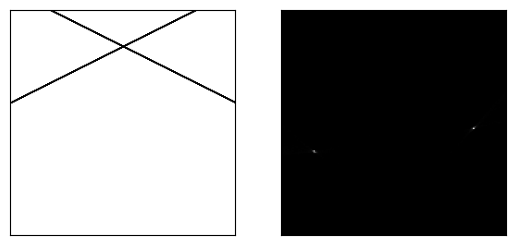

In [2]:
import numpy as np
from libTest import *

In [3]:
sizes = [4 ** i for i in range(2, 6)]
size_img = (64, 64)
size_rrt = (128, 128)
tests = (
    ("empty", [(size_img, size_rrt)]),
    ("full", [(size_img, size_rrt)]),
    ("base", [(size_img, size_rrt)] * 8),
    ("size_1d", [(x, size_rrt) for x in sizes]),
    ("size_2d", sum([[((x, y), size_rrt) for y in sizes] for x in sizes], [])),
    ("size_3d", [(size_img, size_rrt)] * 4),
    ("sev_obj", [(size_img, size_rrt, i // 2) for i in range(4, 12)]),
    ("width", [(size_img, size_rrt, i) for i in range(1, 9)]),
    ("noise", [(size_img, size_rrt, i / 100) for i in range(1, 11)]),
    ("partial", [(size_img, size_rrt, 1 - i / 8) for i in range(1, 8)]),
    ("parallel", [(size_img, size_rrt, i // 2) for i in range(4, 12)]),
    ("loop", [(size_img, size_rrt, i // 2, i % 2 == 1) for i in range(4, 12)]),
    ("circle", [(2 ** i, size_rrt) for i in range(4, 8)]),
)

for name, params in tests:
    t_num = 0
    with open(f"test_{name}.py", "w") as f:
        f.write("from libTest import *\n")
    with open(f"test_{name}.py", "a") as f:
        for param in params:
            param = str(param)[:-1]
            f.write(f"def test_{t_num:_>2}():\n\t{name}_test{param}, '{name}_{t_num:_>2}')\n")
            t_num += 1

random_radon_transformation читает белые пиксели (со значением 255)
как пустые, остальные - как заполненные.
Из этого следуют две вещи:

random_radon_transformation может преобразывать только массивы int
(массив может состоять из float, но пустые пиксели должны быть равны 255).

Размытие бессмыслено проверять - оно лишь увеличивает ширину линий.

In [4]:
!pytest test_empty.py -v

============================= test session starts =============================
platform win32 -- Python 3.8.3, pytest-5.4.3, py-1.9.0, pluggy-0.13.1 -- C:\Users\Lenovo\anaconda3\python.exe
cachedir: .pytest_cache
rootdir: C:\Users\Lenovo\Scripts\IITP\HW3
plugins: hydra-core-1.3.2
collecting ... collected 1 item

test_empty.py::test__0 FAILED                                            [100%]

================================== FAILURES ===================================
___________________________________ test__0 ___________________________________

    def test__0():
>   	empty_test((64, 64), (128, 128), 'empty__0')

test_empty.py:3: 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
libTest.py:156: in empty_test
    img, rrt = start(size_img, size_rrt, 0)
libTest.py:125: in start
    rrt = transform(img, size_rrt)
libTest.py:65: in transform
    rrt = random_radon_transformation(
random_radon_transform.py:43: in random_radon_transformation
    pixel1, p

random_radon_transformation возвращает ошибку
при получении пустого (белого) массива.

In [5]:
!pytest test_full.py -v

============================= test session starts =============================
platform win32 -- Python 3.8.3, pytest-5.4.3, py-1.9.0, pluggy-0.13.1 -- C:\Users\Lenovo\anaconda3\python.exe
cachedir: .pytest_cache
rootdir: C:\Users\Lenovo\Scripts\IITP\HW3
plugins: hydra-core-1.3.2
collecting ... collected 1 item

test_full.py::test__0 FAILED                                             [100%]

================================== FAILURES ===================================
___________________________________ test__0 ___________________________________

    def test__0():
>   	full_test((64, 64), (128, 128), 'full__0')

test_full.py:3: 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

size_img = (64, 64), size_rrt = (128, 128), name = 'full__0'

    def full_test(size_img, size_rrt, name):
        img = np.ones(size_img)
        img, rrt = start(size_img, size_rrt, 0, img = img)
        if (rrt > 0).mean() <= 0.5:
            save_result(img, rrt, name)
>  

random_radon_transformation неэффективен - большая
часть пикселей выходного изображения всегда равна 0.

In [6]:
!pytest test_base.py -v

============================= test session starts =============================
platform win32 -- Python 3.8.3, pytest-5.4.3, py-1.9.0, pluggy-0.13.1 -- C:\Users\Lenovo\anaconda3\python.exe
cachedir: .pytest_cache
rootdir: C:\Users\Lenovo\Scripts\IITP\HW3
plugins: hydra-core-1.3.2
collecting ... collected 8 items

test_base.py::test__0 PASSED                                             [ 12%]
test_base.py::test__1 PASSED                                             [ 25%]
test_base.py::test__2 PASSED                                             [ 37%]
test_base.py::test__3 PASSED                                             [ 50%]
test_base.py::test__4 PASSED                                             [ 62%]
test_base.py::test__5 PASSED                                             [ 75%]
test_base.py::test__6 PASSED                                             [ 87%]
test_base.py::test__7 PASSED                                             [100%]

============================== 8 passed in 

Иногда один из тестов выдают ошибку:

random_radon_transform.py:18: in choice
    idx1 = randint(0, n - 1)
    
Если size_rrt в коде генерации тестов подставить (64, 64)
вместо (128, 128), этой ошибки нет, но ответ может неточным.

In [7]:
!pytest test_size_1d.py -v

============================= test session starts =============================
platform win32 -- Python 3.8.3, pytest-5.4.3, py-1.9.0, pluggy-0.13.1 -- C:\Users\Lenovo\anaconda3\python.exe
cachedir: .pytest_cache
rootdir: C:\Users\Lenovo\Scripts\IITP\HW3
plugins: hydra-core-1.3.2
collecting ... collected 4 items

test_size_1d.py::test__0 FAILED                                          [ 25%]
test_size_1d.py::test__1 FAILED                                          [ 50%]
test_size_1d.py::test__2 FAILED                                          [ 75%]
test_size_1d.py::test__3 FAILED                                          [100%]

================================== FAILURES ===================================
___________________________________ test__0 ___________________________________

    def test__0():
>   	size_1d_test(16, (128, 128), 'size_1d__0')

test_size_1d.py:3: 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
libTest.py:176: in size_1d_test
  

Постоянно тесты выдают ошибку:

random_radon_transform.py:18: in choice
    idx1 = randint(0, n - 1)
    
Если size_rrt в коде генерации тестов подставить (64, 64)
вместо (128, 128), этой ошибки нет, но ответ может неточным.

In [8]:
!pytest test_size_2d.py -v

============================= test session starts =============================
platform win32 -- Python 3.8.3, pytest-5.4.3, py-1.9.0, pluggy-0.13.1 -- C:\Users\Lenovo\anaconda3\python.exe
cachedir: .pytest_cache
rootdir: C:\Users\Lenovo\Scripts\IITP\HW3
plugins: hydra-core-1.3.2
collecting ... collected 16 items

test_size_2d.py::test__0 FAILED                                          [  6%]
test_size_2d.py::test__1 PASSED                                          [ 12%]
test_size_2d.py::test__2 PASSED                                          [ 18%]
test_size_2d.py::test__3 PASSED                                          [ 25%]
test_size_2d.py::test__4 PASSED                                          [ 31%]
test_size_2d.py::test__5 PASSED                                          [ 37%]
test_size_2d.py::test__6 PASSED                                          [ 43%]
test_size_2d.py::test__7 PASSED                                          [ 50%]
test_size_2d.py::test__8 PASSED            

Размер не играет роли для этого алгоритма.

In [9]:
!pytest test_size_3d.py -v

============================= test session starts =============================
platform win32 -- Python 3.8.3, pytest-5.4.3, py-1.9.0, pluggy-0.13.1 -- C:\Users\Lenovo\anaconda3\python.exe
cachedir: .pytest_cache
rootdir: C:\Users\Lenovo\Scripts\IITP\HW3
plugins: hydra-core-1.3.2
collecting ... collected 4 items

test_size_3d.py::test__0 PASSED                                          [ 25%]
test_size_3d.py::test__1 FAILED                                          [ 50%]
test_size_3d.py::test__2 FAILED                                          [ 75%]
test_size_3d.py::test__3 PASSED                                          [100%]

================================== FAILURES ===================================
___________________________________ test__1 ___________________________________

    def test__1():
>   	size_3d_test((64, 64), (128, 128), 'size_3d__1')

test_size_3d.py:5: 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
libTest.py:188: in size_3d_t

Размер не играет роли для этого алгоритма.

In [10]:
!pytest test_sev_obj.py -v

============================= test session starts =============================
platform win32 -- Python 3.8.3, pytest-5.4.3, py-1.9.0, pluggy-0.13.1 -- C:\Users\Lenovo\anaconda3\python.exe
cachedir: .pytest_cache
rootdir: C:\Users\Lenovo\Scripts\IITP\HW3
plugins: hydra-core-1.3.2
collecting ... collected 8 items

test_sev_obj.py::test__0 FAILED                                          [ 12%]
test_sev_obj.py::test__1 FAILED                                          [ 25%]
test_sev_obj.py::test__2 FAILED                                          [ 37%]
test_sev_obj.py::test__3 FAILED                                          [ 50%]
test_sev_obj.py::test__4 FAILED                                          [ 62%]
test_sev_obj.py::test__5 FAILED                                          [ 75%]
test_sev_obj.py::test__6 FAILED                                          [ 87%]
test_sev_obj.py::test__7 FAILED                                          [100%]

================================== FAILURES

random_radon_transformation поддерживает 3d массивы
(правда толку не много так как любое изображение
по итогу обратывается как двумерный массив bool).

In [11]:
!pytest test_width.py -v

============================= test session starts =============================
platform win32 -- Python 3.8.3, pytest-5.4.3, py-1.9.0, pluggy-0.13.1 -- C:\Users\Lenovo\anaconda3\python.exe
cachedir: .pytest_cache
rootdir: C:\Users\Lenovo\Scripts\IITP\HW3
plugins: hydra-core-1.3.2
collecting ... collected 8 items

test_width.py::test__0 PASSED                                            [ 12%]
test_width.py::test__1 PASSED                                            [ 25%]
test_width.py::test__2 PASSED                                            [ 37%]
test_width.py::test__3 PASSED                                            [ 50%]
test_width.py::test__4 PASSED                                            [ 62%]
test_width.py::test__5 FAILED                                            [ 75%]
test_width.py::test__6 FAILED                                            [ 87%]
test_width.py::test__7 PASSED                                            [100%]

================================== FAILURES

Ожидается, что размер пятна как-то соотнился с шириной линии.

В целом всё работает.

In [12]:
!pytest test_noise.py -v

============================= test session starts =============================
platform win32 -- Python 3.8.3, pytest-5.4.3, py-1.9.0, pluggy-0.13.1 -- C:\Users\Lenovo\anaconda3\python.exe
cachedir: .pytest_cache
rootdir: C:\Users\Lenovo\Scripts\IITP\HW3
plugins: hydra-core-1.3.2
collecting ... collected 10 items

test_noise.py::test__0 PASSED                                            [ 10%]
test_noise.py::test__1 PASSED                                            [ 20%]
test_noise.py::test__2 PASSED                                            [ 30%]
test_noise.py::test__3 PASSED                                            [ 40%]
test_noise.py::test__4 PASSED                                            [ 50%]
test_noise.py::test__5 PASSED                                            [ 60%]
test_noise.py::test__6 PASSED                                            [ 70%]
test_noise.py::test__7 PASSED                                            [ 80%]
test_noise.py::test__8 PASSED              

В целом всё работает.

In [13]:
!pytest test_partial.py -v

============================= test session starts =============================
platform win32 -- Python 3.8.3, pytest-5.4.3, py-1.9.0, pluggy-0.13.1 -- C:\Users\Lenovo\anaconda3\python.exe
cachedir: .pytest_cache
rootdir: C:\Users\Lenovo\Scripts\IITP\HW3
plugins: hydra-core-1.3.2
collecting ... collected 7 items

test_partial.py::test__0 FAILED                                          [ 14%]
test_partial.py::test__1 PASSED                                          [ 28%]
test_partial.py::test__2 PASSED                                          [ 42%]
test_partial.py::test__3 PASSED                                          [ 57%]
test_partial.py::test__4 PASSED                                          [ 71%]
test_partial.py::test__5 PASSED                                          [ 85%]
test_partial.py::test__6 PASSED                                          [100%]

================================== FAILURES ===================================
___________________________________ test__0

В целом всё работает.

In [14]:
!pytest test_parallel.py -v

============================= test session starts =============================
platform win32 -- Python 3.8.3, pytest-5.4.3, py-1.9.0, pluggy-0.13.1 -- C:\Users\Lenovo\anaconda3\python.exe
cachedir: .pytest_cache
rootdir: C:\Users\Lenovo\Scripts\IITP\HW3
plugins: hydra-core-1.3.2
collecting ... collected 8 items

test_parallel.py::test__0 PASSED                                         [ 12%]
test_parallel.py::test__1 PASSED                                         [ 25%]
test_parallel.py::test__2 FAILED                                         [ 37%]
test_parallel.py::test__3 PASSED                                         [ 50%]
test_parallel.py::test__4 PASSED                                         [ 62%]
test_parallel.py::test__5 FAILED                                         [ 75%]
test_parallel.py::test__6 FAILED                                         [ 87%]
test_parallel.py::test__7 PASSED                                         [100%]

================================== FAILURES

В целом работает плохо.

In [15]:
!pytest test_loop.py -v

============================= test session starts =============================
platform win32 -- Python 3.8.3, pytest-5.4.3, py-1.9.0, pluggy-0.13.1 -- C:\Users\Lenovo\anaconda3\python.exe
cachedir: .pytest_cache
rootdir: C:\Users\Lenovo\Scripts\IITP\HW3
plugins: hydra-core-1.3.2
collecting ... collected 8 items

test_loop.py::test__0 FAILED                                             [ 12%]
test_loop.py::test__1 PASSED                                             [ 25%]
test_loop.py::test__2 FAILED                                             [ 37%]
test_loop.py::test__3 PASSED                                             [ 50%]
test_loop.py::test__4 PASSED                                             [ 62%]
test_loop.py::test__5 PASSED                                             [ 75%]
test_loop.py::test__6 PASSED                                             [ 87%]
test_loop.py::test__7 PASSED                                             [100%]

================================== FAILURES

В целом работает.

In [16]:
!pytest test_circle.py -v

============================= test session starts =============================
platform win32 -- Python 3.8.3, pytest-5.4.3, py-1.9.0, pluggy-0.13.1 -- C:\Users\Lenovo\anaconda3\python.exe
cachedir: .pytest_cache
rootdir: C:\Users\Lenovo\Scripts\IITP\HW3
plugins: hydra-core-1.3.2
collecting ... collected 4 items

test_circle.py::test__0 PASSED                                           [ 25%]
test_circle.py::test__1 PASSED                                           [ 50%]
test_circle.py::test__2 PASSED                                           [ 75%]
test_circle.py::test__3 PASSED                                           [100%]

============================== 4 passed in 3.61s ==============================


Ожидается, что алгоритм найдёт множество маленьких линий по контуру окружности.

В целом всё работает.